In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
)
import IPython.display as ipd
import warnings
warnings.filterwarnings("ignore")
!pip install librosa resampy

In [1]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [17]:
!kaggle datasets download -d chrisfilo/urbansound8k
!unzip urbansound8k.zip -d UrbanSound8K

Streaming output truncated to the last 5000 lines.
  inflating: UrbanSound8K/fold4/154758-5-0-0.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-1.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-10.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-11.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-12.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-13.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-14.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-15.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-16.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-17.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-18.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-19.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-2.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-20.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-21.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-3.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-4.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-5.wav  
  inflating: UrbanS

In [18]:
!kaggle datasets download -d mmoreaux/environmental-sound-classification-50
!unzip environmental-sound-classification-50.zip -d ESC50

Streaming output truncated to the last 5000 lines.
  inflating: ESC50/audio/audio/16000/2-188822-C-40.wav  
  inflating: ESC50/audio/audio/16000/2-188822-D-40.wav  
  inflating: ESC50/audio/audio/16000/2-196688-A-8.wav  
  inflating: ESC50/audio/audio/16000/2-205966-A-16.wav  
  inflating: ESC50/audio/audio/16000/2-209471-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209472-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209473-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209474-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209475-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209476-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209477-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-209478-A-25.wav  
  inflating: ESC50/audio/audio/16000/2-250710-A-39.wav  
  inflating: ESC50/audio/audio/16000/2-25292-A-22.wav  
  inflating: ESC50/audio/audio/16000/2-25293-A-22.wav  
  inflating: ESC50/audio/audio/16000/2-262579-A-45.wav  
  inflating: ESC50/audio/audio/16000/2-2

In [ ]:
#Metadata and Standardize Labels
urban_meta = pd.read_csv('/content/UrbanSound8K/UrbanSound8K.csv')
esc_meta = pd.read_csv('/content/ESC50/esc50.csv')

# Standardize column names for merging
urban_meta = urban_meta.rename(columns={'slice_file_name': 'file', 'class': 'category'})
esc_meta = esc_meta.rename(columns={'filename': 'file', 'category': 'class'})

# Combine Metadata
urban_meta['dataset'] = 'UrbanSound8K'
esc_meta['dataset'] = 'ESC-50'
combined_meta = pd.concat([urban_meta, esc_meta], ignore_index=True)

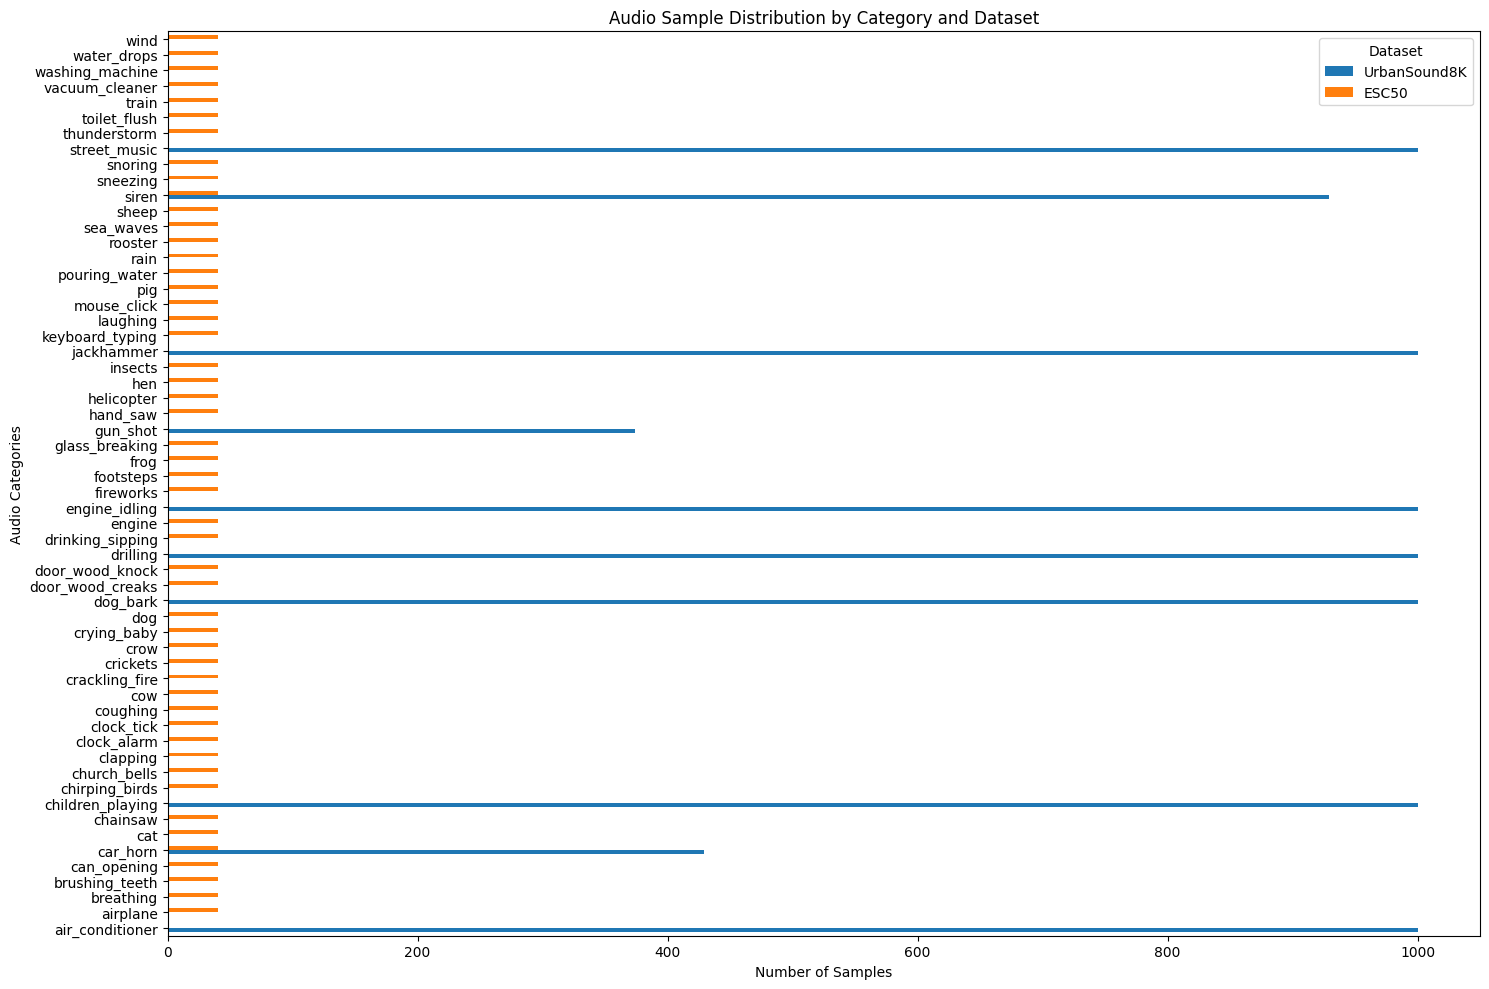

In [ ]:
# Visualize Distribution of Audio Categories

# Count audio types by dataset and category
urban_counts = urban_meta['category'].value_counts()
esc_counts = esc_meta['class'].value_counts()

# a single DataFrame for visualization
combined_counts = pd.DataFrame({
    "UrbanSound8K": urban_counts,
    "ESC50": esc_counts
}).fillna(0)

# Plot
combined_counts.plot(kind='barh', figsize=(15, 10), color=['#1f77b4', '#ff7f0e'])
plt.title("Audio Sample Distribution by Category and Dataset")
plt.xlabel("Number of Samples")
plt.ylabel("Audio Categories")
plt.legend(["UrbanSound8K", "ESC50"], title="Dataset")
plt.tight_layout()
plt.show()

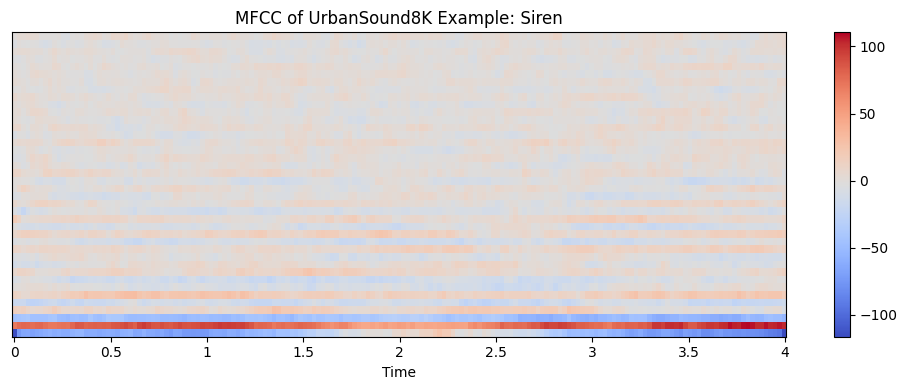

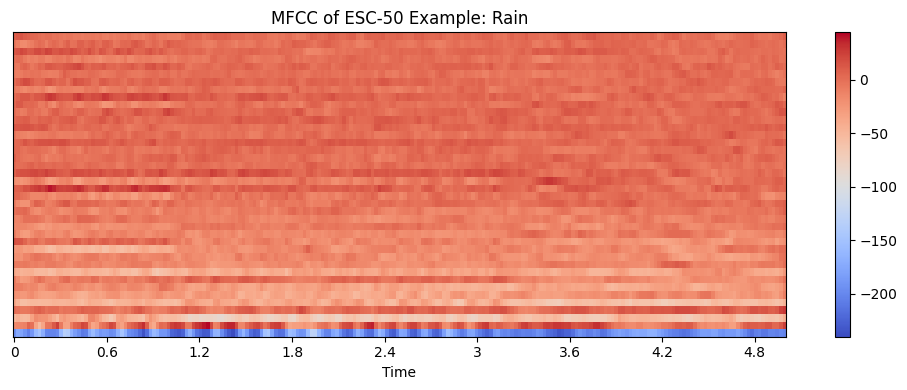

In [ ]:
#MFCC Visualization for Sample Audio Files
def visualize_mfcc(dataset_path, file, title):
    audio_path = os.path.join(dataset_path, file)
    audio, sr = librosa.load(audio_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualize Samples
visualize_mfcc('/content/UrbanSound8K/fold1', '106905-8-0-0.wav', "MFCC of UrbanSound8K Example: Siren")
visualize_mfcc('/content/ESC50/audio/audio/', '1-100038-A-14.wav', "MFCC of ESC-50 Example: Rain")


In [ ]:
# Feature Extraction for UrbanSound8K and ESC-50

def extract_features_urban(metadata, dataset_path):
    features = []
    for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
        # Get the fold (folder) dynamically
        fold = f"fold{row['fold']}"  # e.g., "fold1"
        file_path = os.path.join(dataset_path, fold, row['file'])
        try:
            # Load audio and compute MFCC
            audio, sr = librosa.load(file_path, res_type='kaiser_fast')
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
            features.append([mfcc, row['category']])  # Append features and class
        except Exception as e:
            print(f"Error processing UrbanSound8K file {file_path}: {e}")
    return pd.DataFrame(features, columns=["feature", "class"])

def extract_features_esc(metadata, dataset_path):
    features = []
    for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
        # File path for ESC-50
        file_path = os.path.join(dataset_path, row['file'])
        try:
            # Load audio and compute MFCC
            audio, sr = librosa.load(file_path, res_type='kaiser_fast')
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
            features.append([mfcc, row['class']])  # Append features and class
        except Exception as e:
            print(f"Error processing ESC-50 file {file_path}: {e}")
    return pd.DataFrame(features, columns=["feature", "class"])

urban_features = extract_features_urban(urban_meta, '/content/UrbanSound8K')
esc_features = extract_features_esc(esc_meta, '/content/ESC50/audio/audio')

# Combine both datasets
combined_features = pd.concat([urban_features, esc_features], ignore_index=True)

100%|██████████| 2000/2000 [04:16<00:00,  7.79it/s]


In [ ]:
# Preprocessing the Combined Dataset

# Separate features and labels
X = np.array(combined_features['feature'].tolist())
y = combined_features['class']

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode string labels as integers
Y = to_categorical(y_encoded)    # Convert to one-hot encoding

# Split training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# shapes
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Training Features Shape: (8585, 40)
Testing Features Shape: (2147, 40)
Training Labels Shape: (8585, 58)
Testing Labels Shape: (2147, 58)


In [ ]:
# ANN Model
def build_ann(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ann = build_ann((40,), Y.shape[1])
history_ann = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2757 - loss: 6.3819 - val_accuracy: 0.4541 - val_loss: 2.2387
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4785 - loss: 2.0501 - val_accuracy: 0.5086 - val_loss: 1.9401
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5234 - loss: 1.7959 - val_accuracy: 0.5766 - val_loss: 1.6980
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5859 - loss: 1.5419 - val_accuracy: 0.5650 - val_loss: 1.6837
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6061 - loss: 1.4297 - val_accuracy: 0.5911 - val_loss: 1.5752
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6509 - loss: 1.2963 - val_accuracy: 0.6469 - val_loss: 1.3940
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6792 - loss: 1.1707 - val_accuracy: 0.6623 - val_loss: 1.3885
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6786 - loss: 1.1756 - val_accuracy: 0.

In [ ]:
# CNN1D Model
def build_cnn1d(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn1d = build_cnn1d((40, 1), Y.shape[1])
history_cnn1d = cnn1d.fit(X_train[..., np.newaxis], y_train, validation_data=(X_test[..., np.newaxis], y_test), epochs=20, batch_size=32)


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3702 - loss: 3.1557 - val_accuracy: 0.5235 - val_loss: 1.8076
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5461 - loss: 1.6772 - val_accuracy: 0.5948 - val_loss: 1.5078
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5974 - loss: 1.4336 - val_accuracy: 0.6283 - val_loss: 1.4335
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6314 - loss: 1.2859 - val_accuracy: 0.6302 - val_loss: 1.3939
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6673 - loss: 1.1539 - val_accuracy: 0.6660 - val_loss: 1.3397
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7075 - loss: 1.0286 - val_accuracy: 0.6851 - val_loss: 1.2587
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7158 - loss: 0.9845 - val_accuracy: 0.6851 - val_loss: 1.2581
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7448 - loss: 0.8774 - val_accuracy: 0

In [ ]:
# CNN2D Model
def build_cnn2d(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn2d = build_cnn2d((8, 5, 1), Y.shape[1])
history_cnn2d = cnn2d.fit(X_train.reshape(-1, 8, 5, 1), y_train, validation_data=(X_test.reshape(-1, 8, 5, 1), y_test), epochs=20, batch_size=32)


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2725 - loss: 4.5105 - val_accuracy: 0.4746 - val_loss: 1.9785
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4819 - loss: 1.8936 - val_accuracy: 0.5249 - val_loss: 1.8295
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5348 - loss: 1.6880 - val_accuracy: 0.5654 - val_loss: 1.6422
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5757 - loss: 1.5209 - val_accuracy: 0.5561 - val_loss: 1.6141
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5983 - loss: 1.4094 - val_accuracy: 0.6139 - val_loss: 1.4722
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6288 - loss: 1.3067 - val_accuracy: 0.6157 - val_loss: 1.4580
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6428 - loss: 1.2427 - val_accuracy: 0.6409 - val_loss: 1.3676
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6756 - loss: 1.1364 - val_accuracy: 0.

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN - Precision: 0.7389, Recall: 0.7424, F1-Score: 0.7304


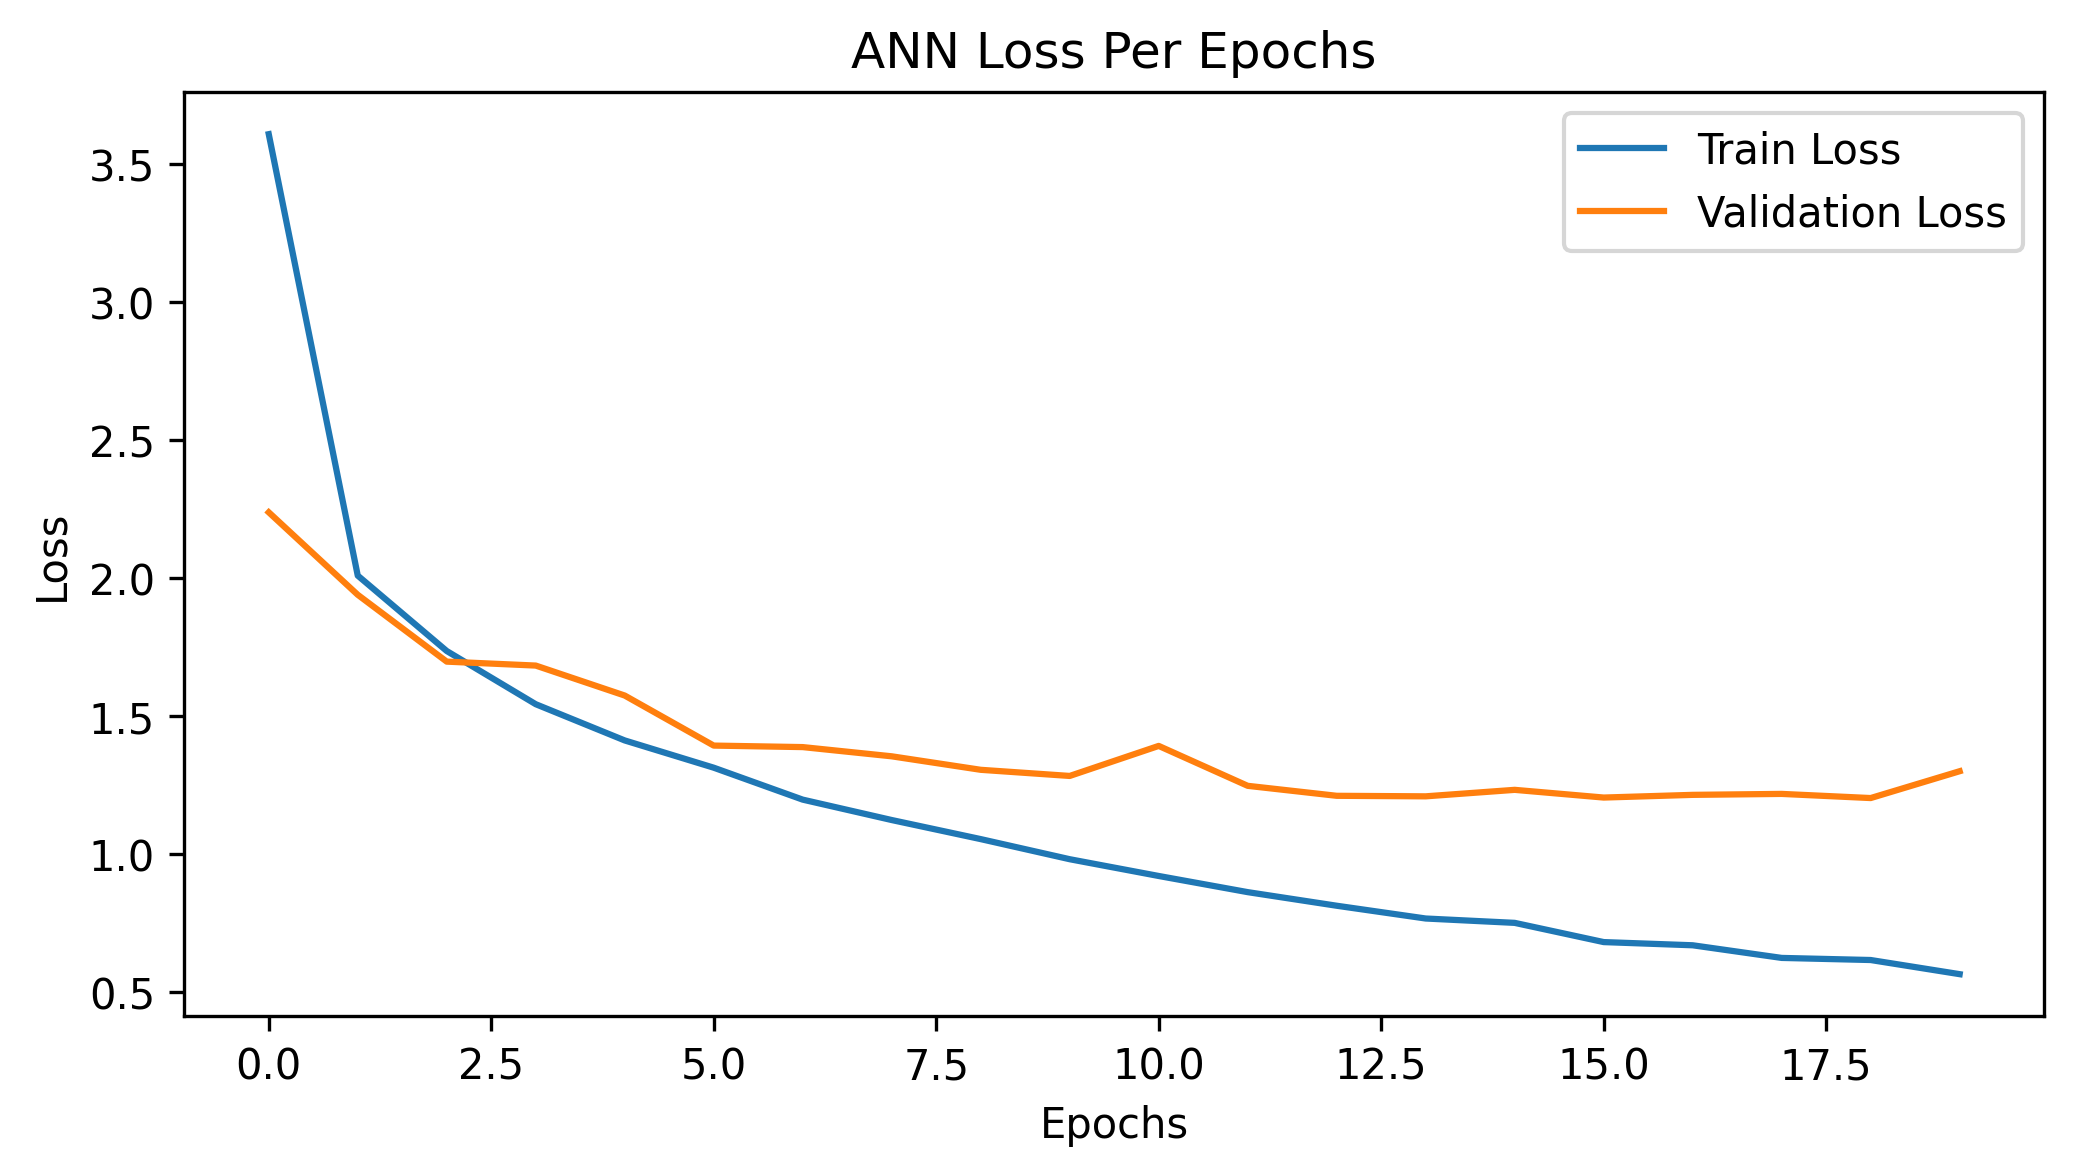

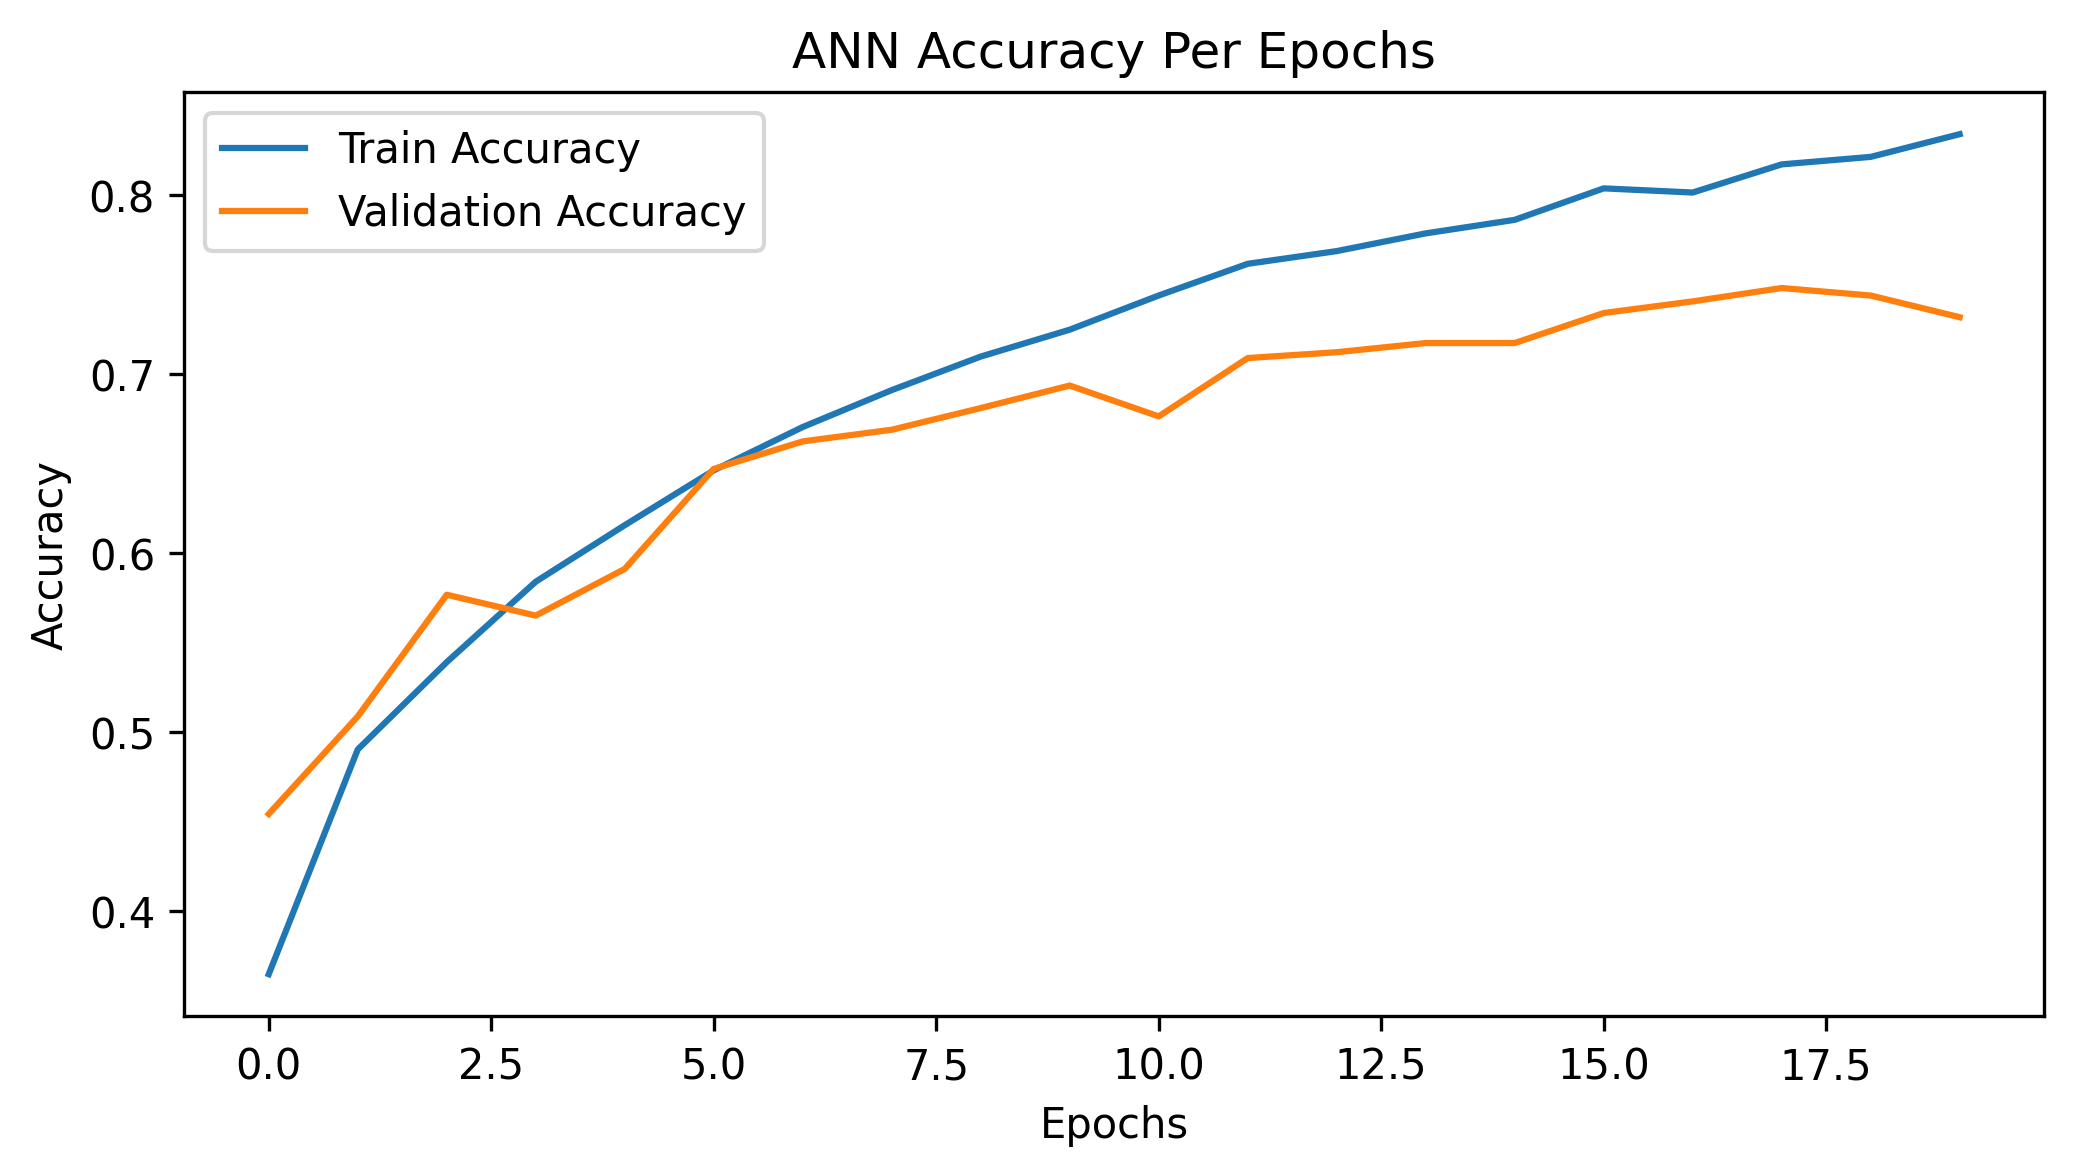

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CNN1D - Precision: 0.7423, Recall: 0.7452, F1-Score: 0.7309


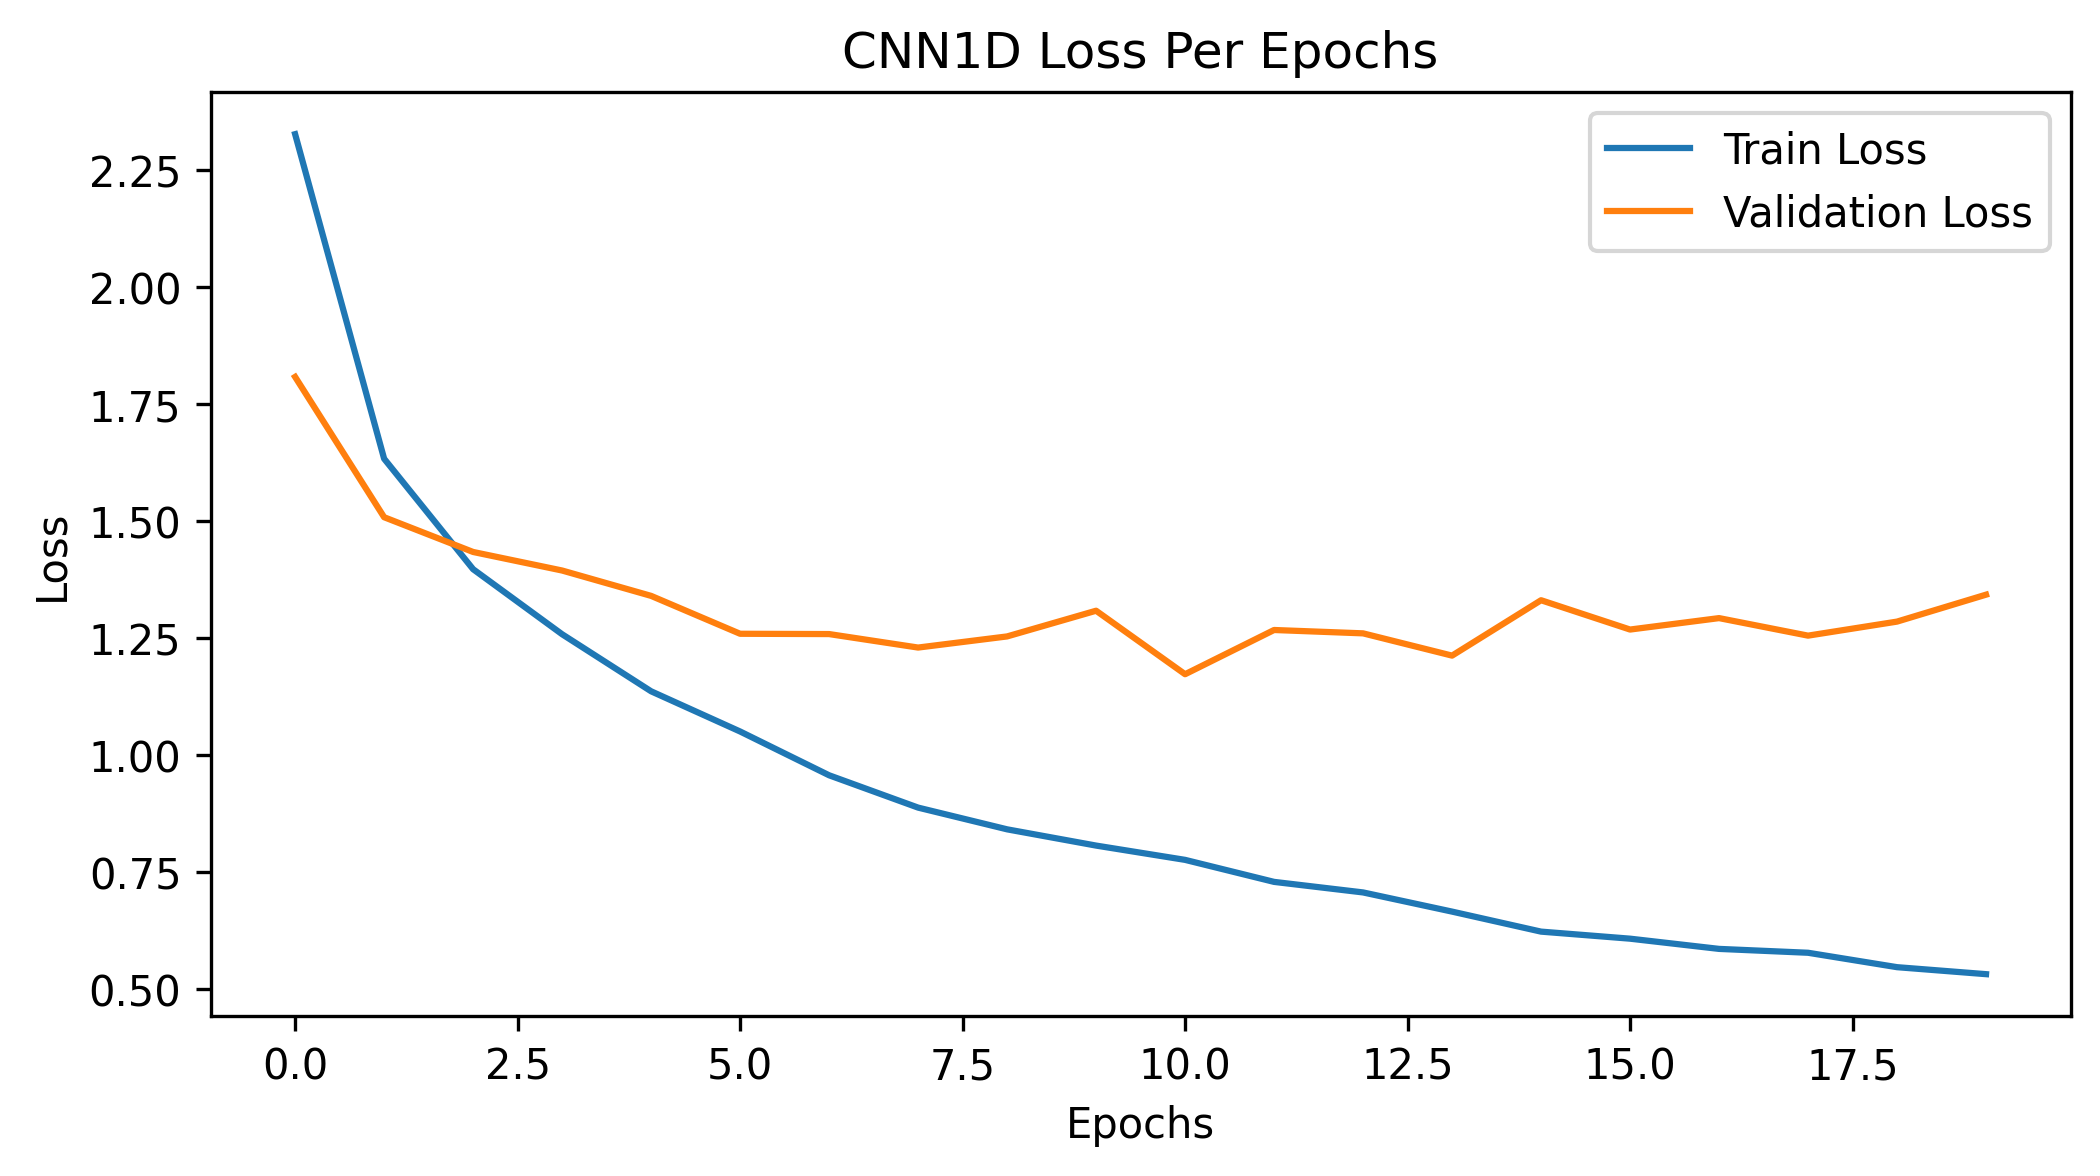

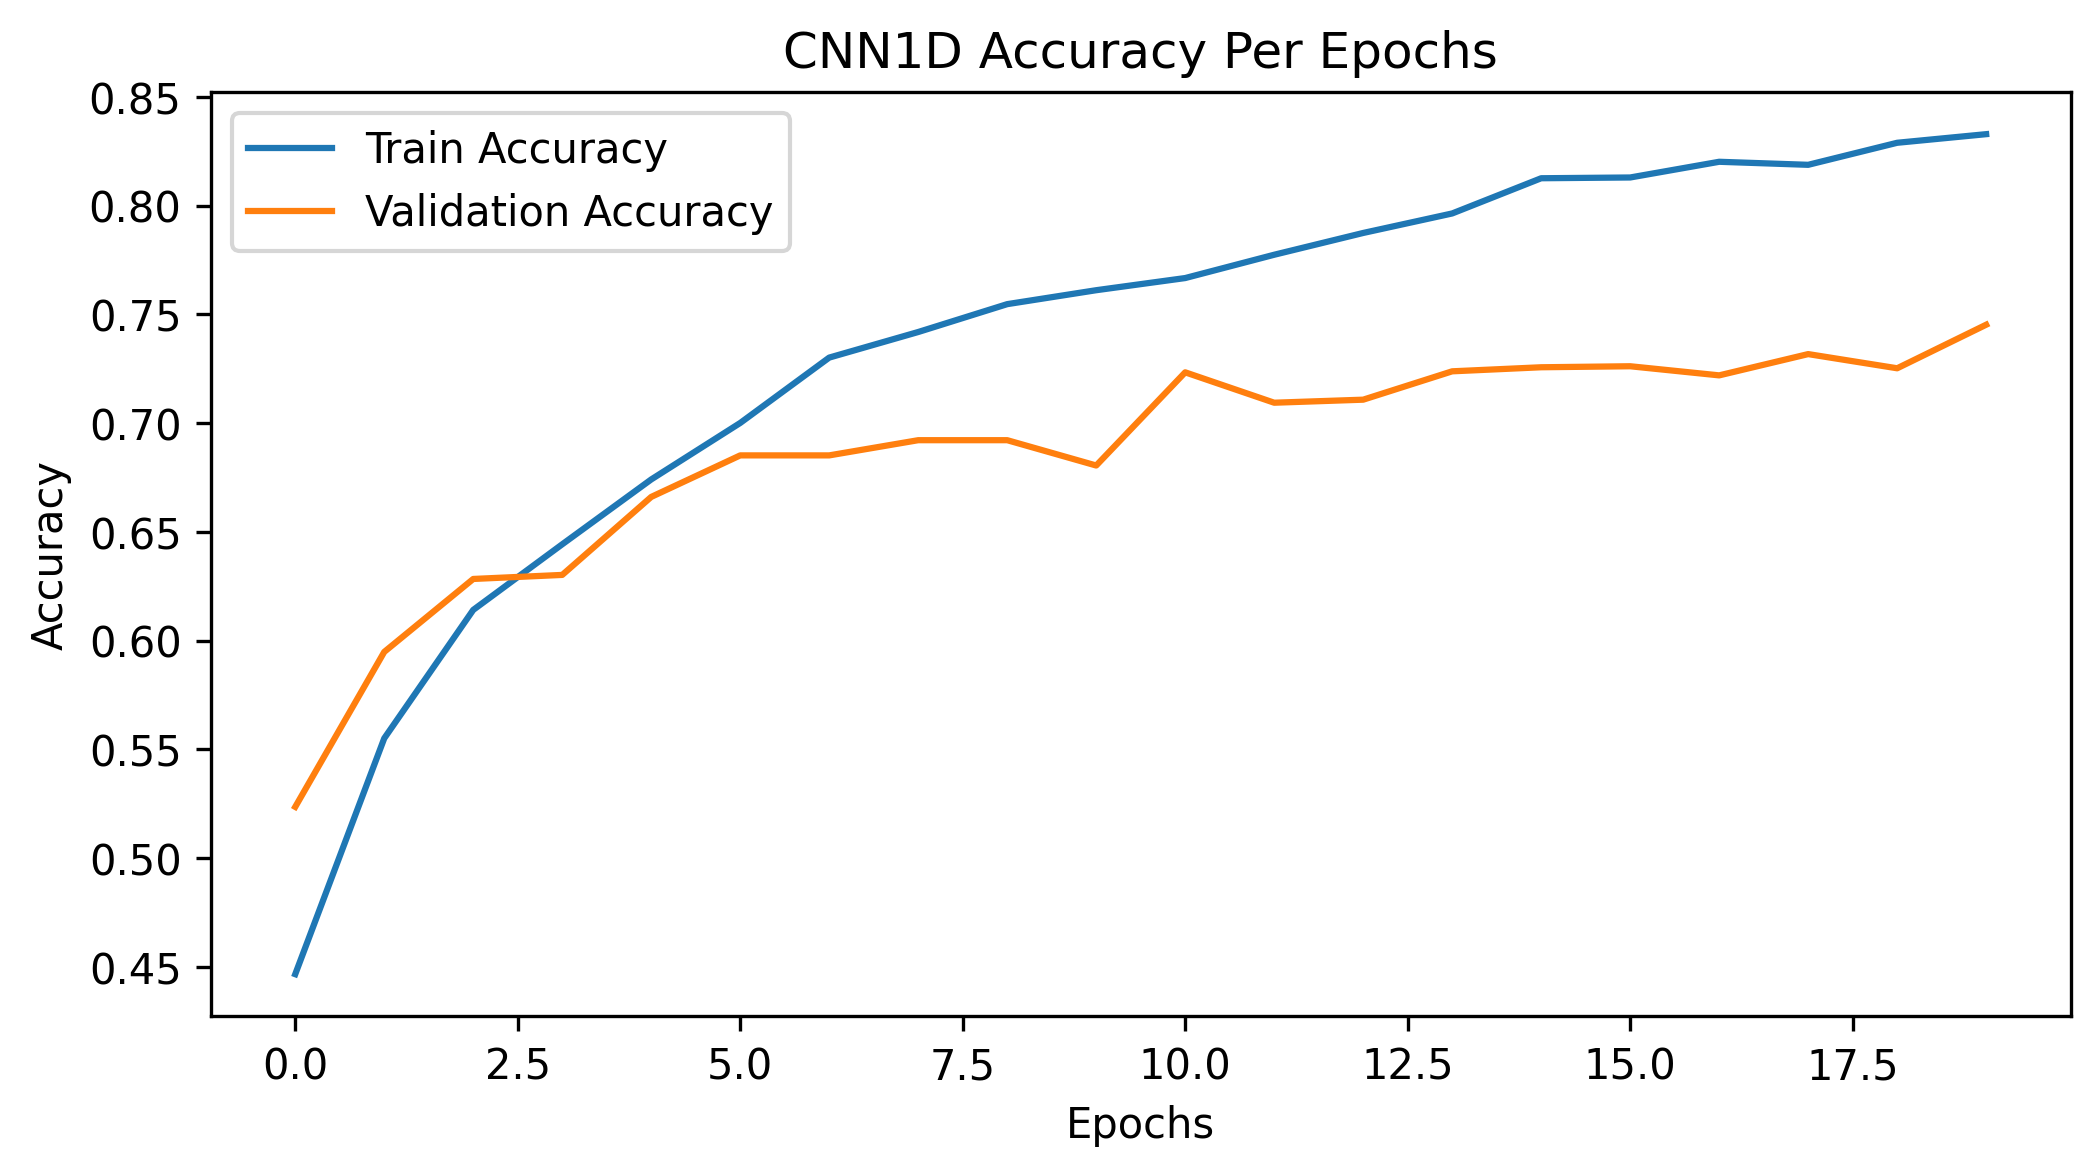

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN2D - Precision: 0.7090, Recall: 0.7266, F1-Score: 0.7080


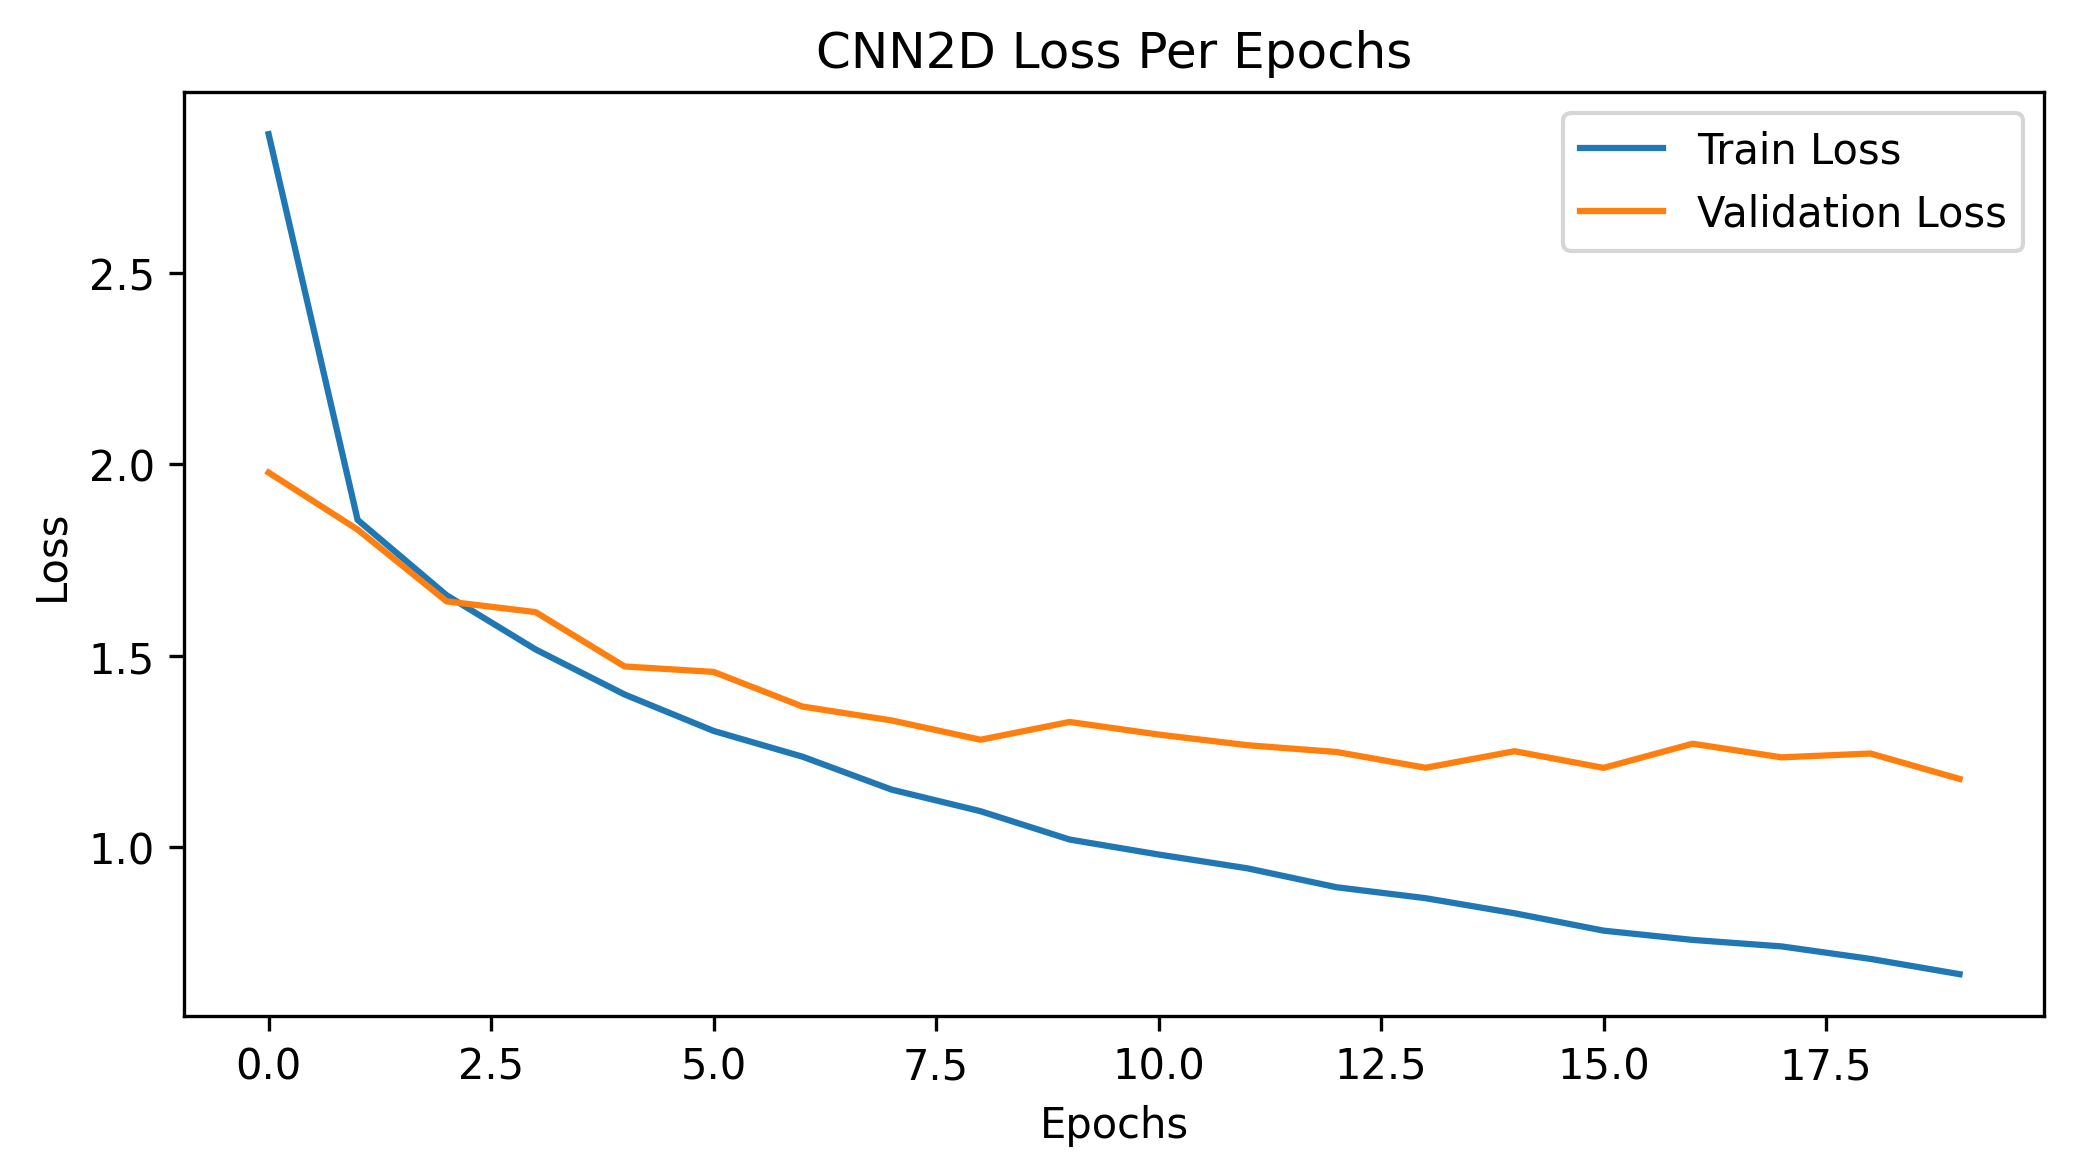

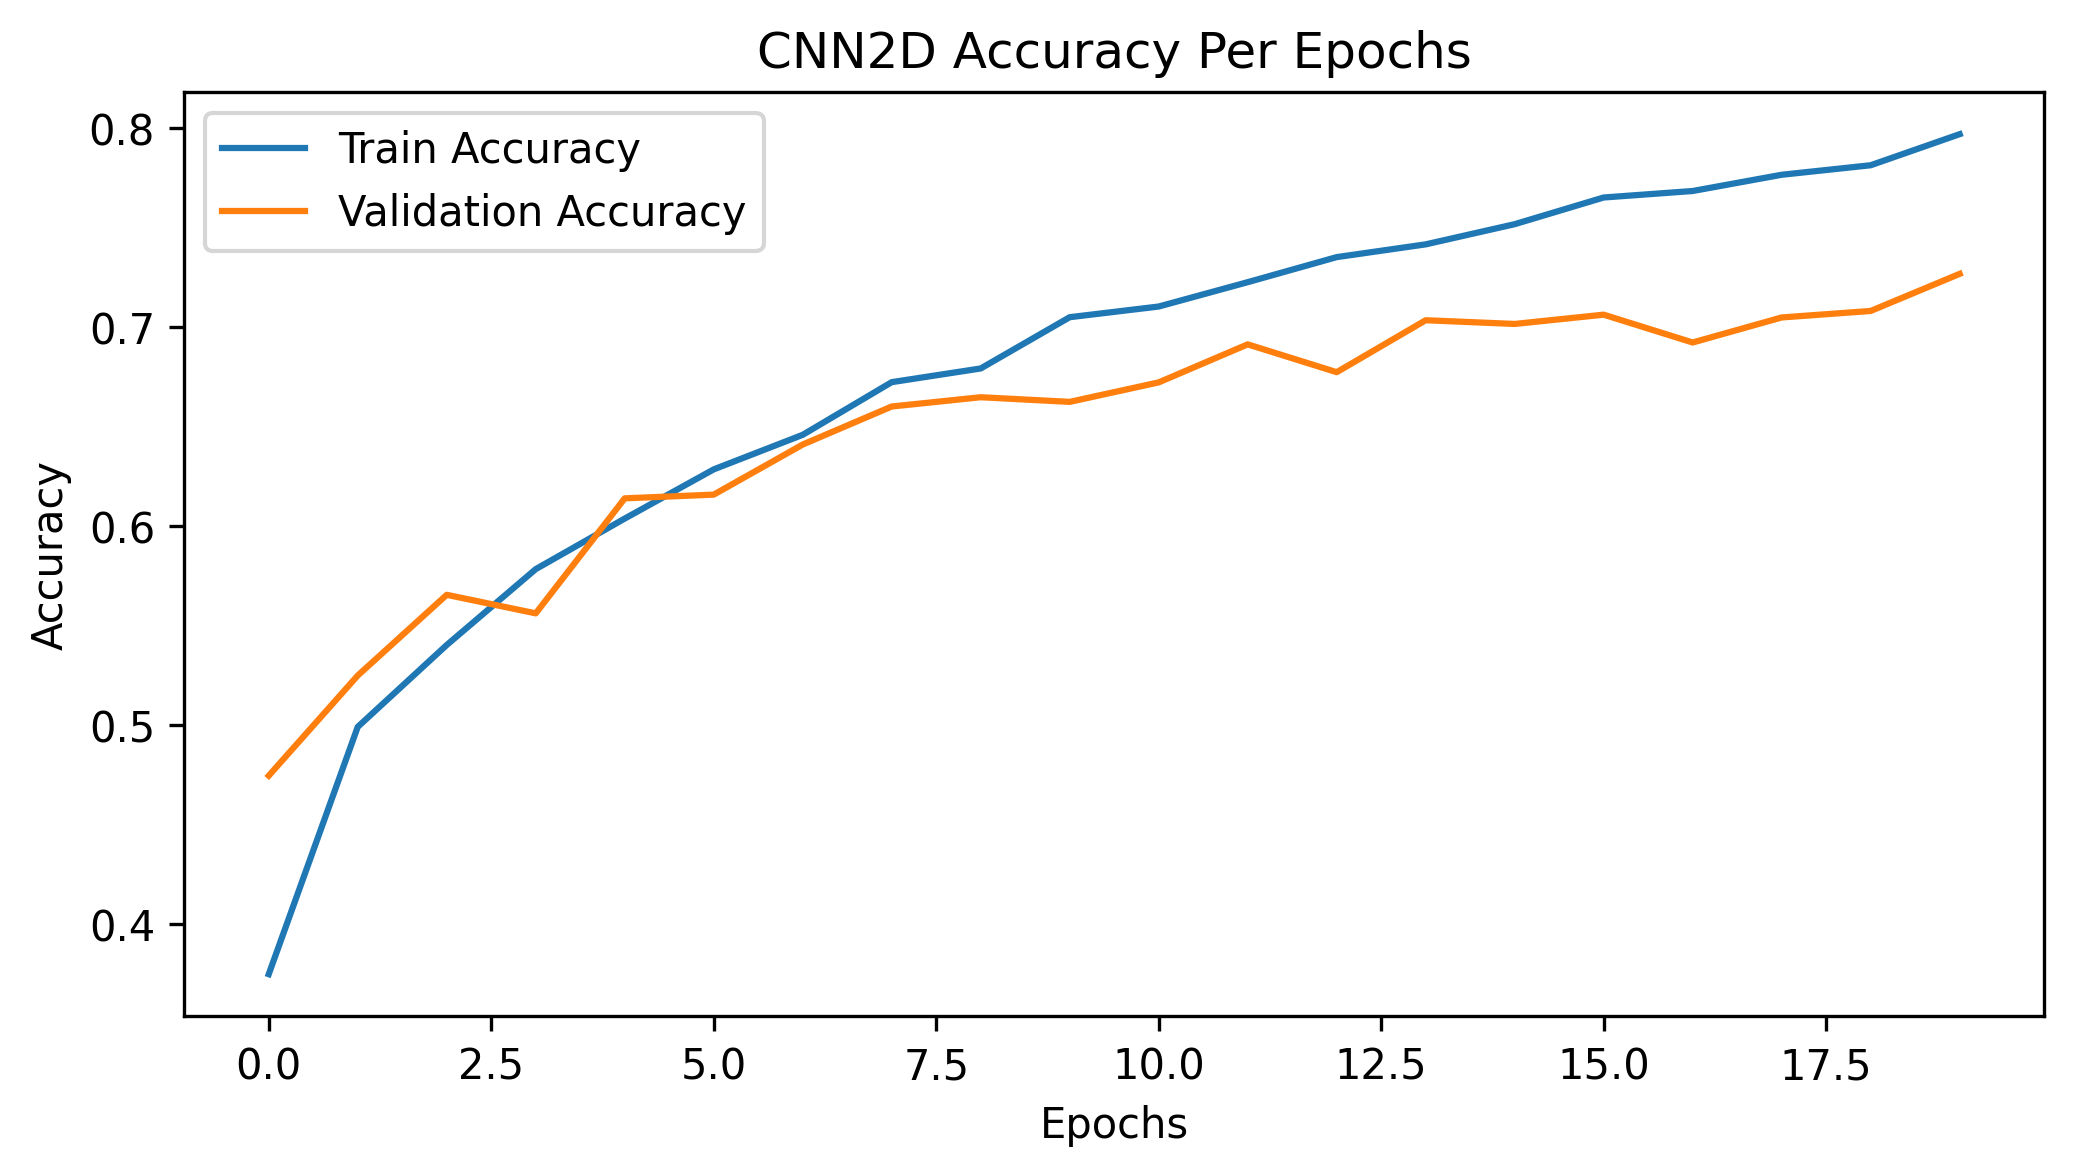

In [45]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Function to plot training and validation loss
def plot_loss(history, model_name):
    plt.figure(figsize=(8, 4), dpi=300)  # Reduced figure size
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title(f"{model_name} Loss Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

# Function to plot training and validation accuracy
def plot_accuracy(history, model_name):
    plt.figure(figsize=(8, 4), dpi=300)  # Reduced figure size
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title(f"{model_name} Accuracy Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

# Function to evaluate the model and print metrics
def evaluate_model(model, X_test, y_test, history, model_name):
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Print only relevant metrics (Precision, Recall, F1-score)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Loss and accuracy plots
    plot_loss(history, model_name)
    plot_accuracy(history, model_name)

# ===================
# Evaluate ANN Model
# ===================
# Use the pre-trained history for ANN
evaluate_model(ann, X_test, y_test, history_ann, "ANN")

# ========================
# Evaluate CNN1D Model
# ========================
# Use the pre-trained history for CNN1D
evaluate_model(cnn1d, X_test[..., np.newaxis], y_test, history_cnn1d, "CNN1D")

# =========================
# Evaluate CNN2D Model
# =========================
# Use the pre-trained history for CNN2D
evaluate_model(cnn2d, X_test.reshape(-1, 8, 5, 1), y_test, history_cnn2d, "CNN2D")

In [ ]:
# Save Trained Models

# file paths for saving models
ann_model_path = "ANN_model.h5"
cnn1d_model_path = "CNN1D_model.h5"
cnn2d_model_path = "CNN2D_model.h5"

ann.save(ann_model_path)
print(f"ANN model saved to {ann_model_path}")

cnn1d.save(cnn1d_model_path)
print(f"CNN1D model saved to {cnn1d_model_path}")

cnn2d.save(cnn2d_model_path)
print(f"CNN2D model saved to {cnn2d_model_path}")


ANN model saved to ANN_model.h5
CNN1D model saved to CNN1D_model.h5
CNN2D model saved to CNN2D_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


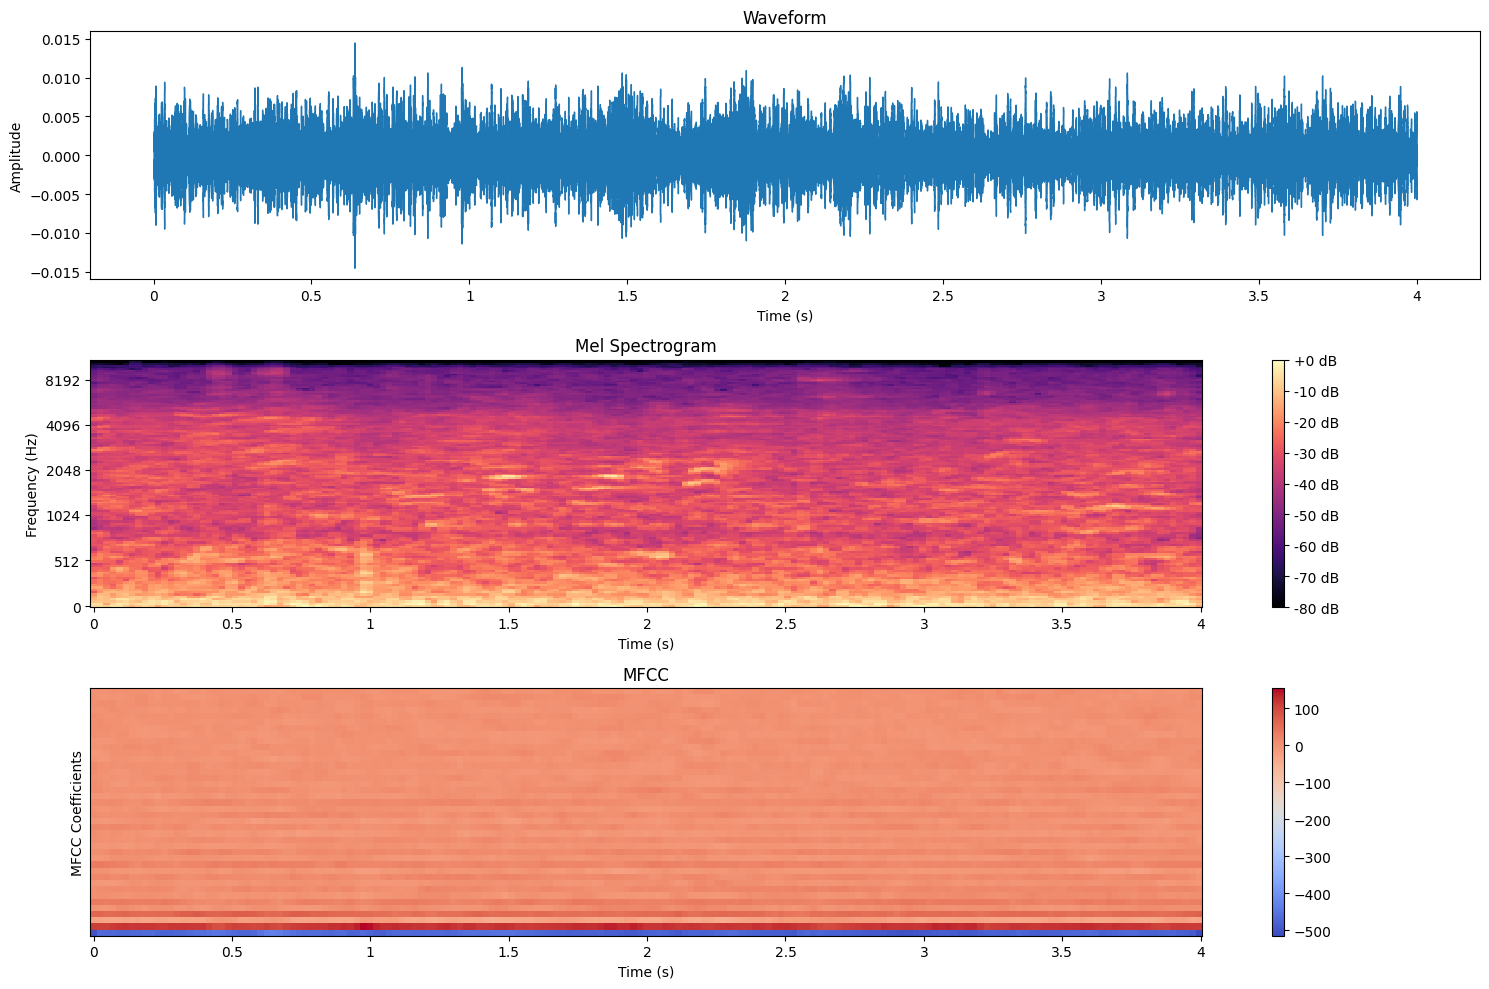

Predictions for the sample file:
ANN Prediction: children_playing
CNN1D Prediction: children_playing
CNN2D Prediction: children_playing


In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# function to test and visualize a sample file
def test_and_visualize_sample(audio_file, ann_path="ANN_model.h5", cnn1d_path="CNN1D_model.h5", cnn2d_path="CNN2D_model.h5"):
    # Load the models
    ann = load_model(ann_path)
    cnn1d = load_model(cnn1d_path)
    cnn2d = load_model(cnn2d_path)

    # Preprocess the audio file
    def preprocess_audio(file_path):
        # Load the audio file
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')
        # Extract MFCC features
        mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
        return audio, sr, mfcc

    # Process the input audio file
    audio, sr, features = preprocess_audio(audio_file)

    # Reshape for each model's input requirements
    ann_input = features.reshape(1, -1)  # ANN expects (1, 40)
    cnn1d_input = features.reshape(1, 40, 1)  # CNN1D expects (1, 40, 1)
    cnn2d_input = features.reshape(1, 8, 5, 1)  # CNN2D expects (1, 8, 5, 1)

    # Predict using the models
    ann_pred = ann.predict(ann_input)
    cnn1d_pred = cnn1d.predict(cnn1d_input)
    cnn2d_pred = cnn2d.predict(cnn2d_input)

    # Decode predictions
    predicted_ann = le.inverse_transform([np.argmax(ann_pred)])
    predicted_cnn1d = le.inverse_transform([np.argmax(cnn1d_pred)])
    predicted_cnn2d = le.inverse_transform([np.argmax(cnn2d_pred)])

    # Visualizations
    plt.figure(figsize=(15, 10))

    # Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(3, 1, 2)
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title("MFCC")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

    plt.tight_layout()
    plt.show()

    # predictions
    return {
        "ANN Prediction": predicted_ann[0],
        "CNN1D Prediction": predicted_cnn1d[0],
        "CNN2D Prediction": predicted_cnn2d[0]
    }

# sample audio file
sample_file = "/content/UrbanSound8K/fold5/100263-2-0-161.wav"
predictions = test_and_visualize_sample(sample_file)

# results
print("Predictions for the sample file:")
for model, prediction in predictions.items():
    print(f"{model}: {prediction}")